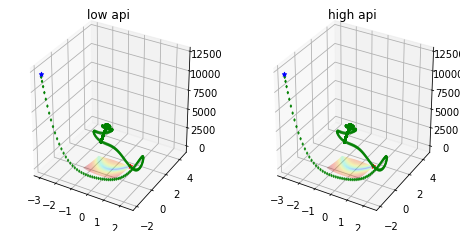

In [16]:
# Copyright 2019 The PULIBC AI Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================


import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import numpy as np


def rosenbrock (x, y):
    return (1-x) ** 2 + 100*(y - x**2) ** 2


# start point 
start_x, start_y = -3., -2.
start_z = rosenbrock(start_x, start_y)
start_xy = tf.constant([start_x, start_y])
xy = tf.Variable(initial_value=start_xy, dtype=tf.float32, name='xy')

# xy coordinate with z
x, y = np.meshgrid(np.arange(-1, 1, 0.01), np.arange(-1, 1, 0.01))
z = rosenbrock(x, y)

# find minimum z
index = np.argmin(np.ravel(z))
min_x, min_y, min_z = list(map(lambda k: np.ravel(k)[index], [x, y, z]))

# init momentum vector 
v = tf.Variable(initial_value=tf.constant([0., 0.]), dtype=tf.float32, name='v')

# get gradients
grad_xy = tf.gradients((1-xy[0]) ** 2 + 100*(xy[1] - xy[0]**2) ** 2, xy)[0]

# NAG Momentum vector update
beta = 0.99
lr = 0.000001
v_assign = tf.assign(ref=v, value=(v * beta) - (lr * grad_xy))
step = tf.assign_add(xy,  (v_assign * beta) - (grad_xy * lr))

# impletemented by tensorflow high api 
step_api = tf.train.MomentumOptimizer(lr, beta, use_nesterov=True).minimize(
    (1-xy[0]) ** 2 + 100*(xy[1] - xy[0]**2) ** 2)



# z 값중 최소값 찾기
steps = [step, step_api] 
titles = ['low api', 'high api'] 
fig = plt.figure(figsize=plt.figaspect(0.5))
for ind in range(2):
    ax = fig.add_subplot(1,2,ind+1,projection='3d')
    # plot start point 
    ax.plot_surface(x, y, z, cmap=plt.cm.jet, alpha=0.3, norm=LogNorm())
    ax.scatter(xs=min_x, ys=min_y, marker='*', color='r')
    ax.scatter(xs=start_x, ys=start_y, zs=rosenbrock(-3, -2), marker='*', color='b')

    # Session
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    xy_history = []
    v_history = []
    for i in range(15000):
        _, xy_, v_ = sess.run([steps[ind], xy, v])
        xy_history.append(xy_)
        v_history.append(v_)
    xy_history = np.stack(xy_history, axis=0)
    ax.scatter(xs=xy_history[:, 0], ys=xy_history[:, 1], zs=rosenbrock(xy_history[:, 0], xy_history[:, 1]),
               marker='d', color='g', s=3)
    ax.set_title(titles[ind])
plt.show()
